# Uniform Trajectory

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ScoreMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, DeepKernel
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, traj_to_line

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [7]:
key = jax.random.PRNGKey(0)

## Data

In [8]:
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

In [46]:
lb =  jnp.zeros(2)
ub =  jnp.ones(2)
bounds = jnp.array([lb, ub])
uni_pdf = lambda x: 1 / jnp.prod(ub - lb) 

X_grid = grid(bounds, N=100, flatten=False)
X_flat = grid(bounds, N=100)
prob_X_flat = jax.vmap(uni_pdf)(X_flat)

n_traj = 100
samples = grid(bounds, N=20)
samples_xl = grid(bounds, N=40)
sample_grid = grid(bounds, N=20, flatten=False)
prob_s = jax.vmap(uni_pdf)(samples)
prob_s_xl = jax.vmap(uni_pdf)(samples_xl)

traj_init = jnp.linspace(lb, ub, num=n_traj, endpoint=True)
traj_init_med = jnp.linspace(lb, ub, num=n_traj * 2, endpoint=True)
traj_init_long = jnp.linspace(lb, ub, num=n_traj * 4, endpoint=True)
traj_init_xl = jnp.linspace(lb, ub, num=n_traj * 8, endpoint=True)



# traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)

### Initial Plot

In [12]:
pdf_recon_init = ergodic_metric(traj_init, bounds, n_modes=20, n_per_dim=100)
pdf_true = jax.vmap(uni_pdf)(X_flat)

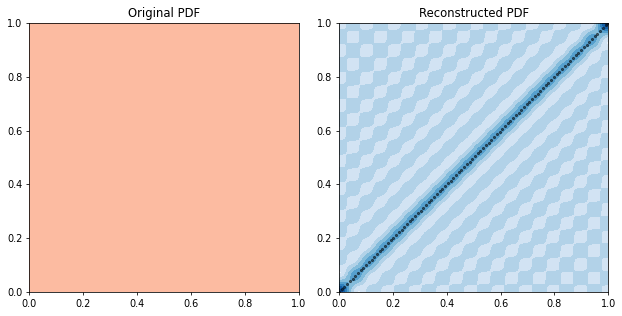

In [13]:
# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Original PDF')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], pdf_true.reshape(100, 100), cmap='Reds')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Reconstructed PDF')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], pdf_recon_init.reshape(100, 100), cmap='Blues')
ax.scatter(traj_init[:,0], traj_init[:,1], c='k', s=5, alpha=0.5)

plt.show()
plt.close()

## Model Definitions

In [16]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z, t.q_params, t.l]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [17]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            model_trained, model_loss = train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

            return model_trained, model_loss

    else:
        def training_fn(model):
            model_trained, model_loss = train_mmd(
                key, model, samples, bounds, aux_loss=traj_loss_fn, 
                opt_params=solver_params
            )

            return model_trained, model_loss

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [18]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [20]:
power_params = {'epochs': epochs_k, 'lr': lr}
gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': False
}
score_params = {
    'lr': 1e-3, 'q': 'normal',
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

### Short Length

In [21]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, power_params, gp_params, score_params
)
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

Training power
Training gp
Training score
epoch 0,loss: 6667.608717289243
epoch 50,loss: 2822.2432756673356
epoch 100,loss: 2349.3713980449706
epoch 150,loss: 1915.2469496430188
epoch 200,loss: 1789.579196630026
epoch 250,loss: 1791.681332814747
epoch 300,loss: 1213.132834944289
epoch 350,loss: 1105.4824085990724
epoch 400,loss: 883.192478755852
epoch 450,loss: 558.3263919750862
epoch 500,loss: 430.8022905339951
epoch 550,loss: 430.85863705546063
epoch 600,loss: 402.7877280873944
epoch 650,loss: 277.5692134794779
epoch 700,loss: 277.8327426803587
epoch 750,loss: 168.942489979382
epoch 800,loss: 247.91296117690118
epoch 850,loss: 148.68812570310882
epoch 900,loss: 118.86246965693418
epoch 950,loss: 128.40388021617497
epoch 1000,loss: 120.32889024849068
epoch 1050,loss: 88.89930598614373
epoch 1100,loss: 111.58547125503608
epoch 1150,loss: 93.82082558565811
epoch 1200,loss: 73.4942188970898
epoch 1250,loss: 91.33510953500179
epoch 1300,loss: 39.5339749085057
epoch 1350,loss: 72.523625668

In [36]:
for model in rbf_models:
    print(model.k.transform._scale)

[0.31578947 0.31578947]
[0.22397299 0.22723948]
[1.26394871 1.26963002]
[0.47043445 0.35742407]


Train trajectories with MMD:

In [52]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, bounds=None, aux_loss=traj_loss_fn,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Medium Length

In [33]:
rbf_init_med, rbf_power_med, rbf_gp_med, rbf_score_med = train_rbf_kernels(
    key, traj_init_med, samples, prob_s, bounds, power_params, gp_params, score_params
)

Training power
Training gp
Training score
epoch 0,loss: 6377.268856909765
epoch 50,loss: 2632.896940468034
epoch 100,loss: 2344.5547248955213
epoch 150,loss: 1944.1110338414085
epoch 200,loss: 1797.4653884327442
epoch 250,loss: 1800.9514194521412
epoch 300,loss: 1143.6517220772948
epoch 350,loss: 968.4446987435522
epoch 400,loss: 790.5161693787776
epoch 450,loss: 480.7199255451031
epoch 500,loss: 390.0368190589251
epoch 550,loss: 378.3073003514828
epoch 600,loss: 331.8638695361954
epoch 650,loss: 234.43596099222728
epoch 700,loss: 248.01276433787513
epoch 750,loss: 152.45678404024133
epoch 800,loss: 214.13682314438591
epoch 850,loss: 128.24314827158796
epoch 900,loss: 112.24396634657859
epoch 950,loss: 108.39539358992081
epoch 1000,loss: 94.76201666837946
epoch 1050,loss: 82.15134014846146
epoch 1100,loss: 89.83604949252455
epoch 1150,loss: 72.89283715467437
epoch 1200,loss: 61.222768946684205
epoch 1250,loss: 64.04348368485151
epoch 1300,loss: 33.44672345176478
epoch 1350,loss: 59.537

In [53]:
rbf_models_med = (rbf_init_med, rbf_power_med, rbf_gp_med, rbf_score_med)

rbf_traj_init_med, rbf_power_traj_med, rbf_gp_traj_med, rbf_score_traj_med = train_trajectories(
        key, rbf_models_med, samples, bounds=None, aux_loss=traj_loss_fn,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Long Length

In [39]:
rbf_init_long, rbf_power_long, rbf_gp_long, rbf_score_long = train_rbf_kernels(
    key, traj_init_long, samples, prob_s, bounds, power_params, gp_params, score_params
)
rbf_models_long = (rbf_init_long, rbf_power_long, rbf_gp_long, rbf_score_long)

Training power
Training gp
Training score
epoch 0,loss: 6182.682337178795
epoch 50,loss: 2554.0234215485407
epoch 100,loss: 2248.694574352218
epoch 150,loss: 1833.7819710239278
epoch 200,loss: 1705.9961200083865
epoch 250,loss: 1671.678432481005
epoch 300,loss: 1062.0297075218689
epoch 350,loss: 884.237845860399
epoch 400,loss: 759.6995989411204
epoch 450,loss: 474.2883990962966
epoch 500,loss: 403.7009511755223
epoch 550,loss: 402.30829208213265
epoch 600,loss: 362.79138398295987
epoch 650,loss: 257.430907094932
epoch 700,loss: 242.5072197618723
epoch 750,loss: 170.3684212315334
epoch 800,loss: 236.9203258745307
epoch 850,loss: 148.13177872318767
epoch 900,loss: 114.59180652236692
epoch 950,loss: 116.19946594013487
epoch 1000,loss: 102.74672956172229
epoch 1050,loss: 85.60252577520488
epoch 1100,loss: 91.81543402917103
epoch 1150,loss: 76.49195571571646
epoch 1200,loss: 62.06946904479188
epoch 1250,loss: 63.040358147980264
epoch 1300,loss: 34.200537577542114
epoch 1350,loss: 60.153877

In [54]:

rbf_traj_init_long, rbf_power_traj_long, rbf_gp_traj_long, rbf_score_traj_long = train_trajectories(
        key, rbf_models_long, samples, bounds=None, aux_loss=traj_loss_fn,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### XL

In [47]:
rbf_init_xl, rbf_power_xl, rbf_gp_xl, rbf_score_xl = train_rbf_kernels(
    key, traj_init_xl, samples_xl, prob_s_xl, bounds, power_params, gp_params, score_params
)

Training power
Training gp
Training score
epoch 0,loss: 2020.3172002890574
epoch 50,loss: 446.77448995753804
epoch 100,loss: 125.7347074256355
epoch 150,loss: 42.729486960417326
epoch 200,loss: 19.24311348832173
epoch 250,loss: 26.00910721474942
epoch 300,loss: 7.849443361447898
epoch 350,loss: 5.305551962273223
epoch 400,loss: 7.5838361020868055
epoch 450,loss: 2.4460626018622573
epoch 500,loss: 0.35559562540981027
epoch 550,loss: -1.8117261703056693
epoch 600,loss: 0.7383020138580217
epoch 650,loss: -1.9208539405718366
epoch 700,loss: -0.8103959341070808
epoch 750,loss: -3.0150636577449266
epoch 800,loss: -3.9614209076206013
epoch 850,loss: -4.14597577937488
epoch 900,loss: -5.786914782607349
epoch 950,loss: -6.601791348856419
epoch 1000,loss: -6.9848583863268185
epoch 1050,loss: -9.892097254175315
epoch 1100,loss: -10.96442862439233
epoch 1150,loss: -12.035467379716714
epoch 1200,loss: -16.379193402150896
epoch 1250,loss: -12.918932368135744
epoch 1300,loss: -17.008829953455677
epoc

In [50]:
rbf_models_xl = (rbf_init_xl, rbf_power_xl, rbf_gp_xl, rbf_score_xl)

rbf_traj_init_xl, rbf_power_traj_xl, rbf_gp_traj_xl, rbf_score_traj_xl = train_trajectories(
        key, rbf_models_xl, samples_xl, bounds=None, aux_loss=traj_loss_fn,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


#### Misc Plots

Visualize the probability surfaces of the gp and score predictions

In [95]:
gp_preds = gp_pred(rbf_gp.k, samples, prob_s, X_flat)[0]
gp_preds = gp_preds.reshape(100, 100)

z = jax.random.choice(key, samples, shape=(100,), replace=False)
score = ScoreDensity(key, rbf_score.k, z)
score_preds = jnp.exp(score.log_density(X_flat))
score_preds = score_preds.reshape(100, 100)

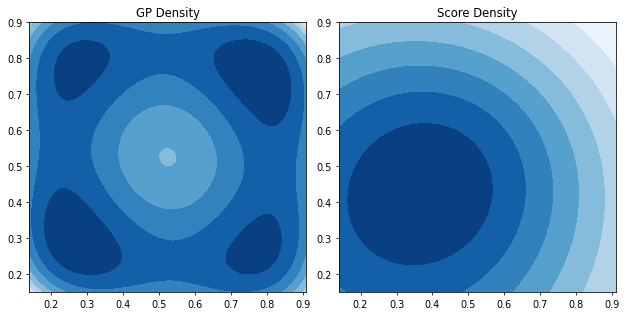

In [99]:
# visualize for comparison
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('GP Density')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], gp_preds, cmap='Blues')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Score Density')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], score_preds, cmap='Blues')

plt.show()
plt.close()

### Plot Trajectories

Visualize trajectories:

<Axes: >

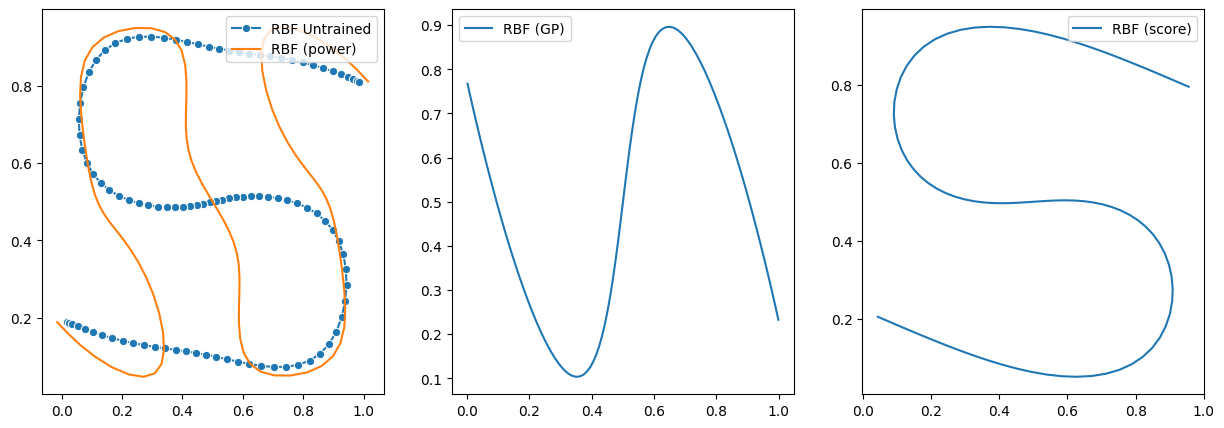

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])

sns.lineplot(
    x=rbf_traj_init.w[:, 0], y=rbf_traj_init.w[:,1], label="RBF Untrained", 
    ax=ax[0], sort=False, marker="o"
)
sns.lineplot(
    x=rbf_power_traj.w[:, 0], y=rbf_power_traj.w[:,1], label="RBF (power)", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_gp_traj.w[:, 0], y=rbf_gp_traj.w[:,1], label="RBF (GP)", 
    ax=ax[1], sort=False
)
sns.lineplot(
    x=rbf_score_traj.w[:, 0], y=rbf_score_traj.w[:,1], label="RBF (score)", 
    ax=ax[2], sort=False
)

<Axes: >

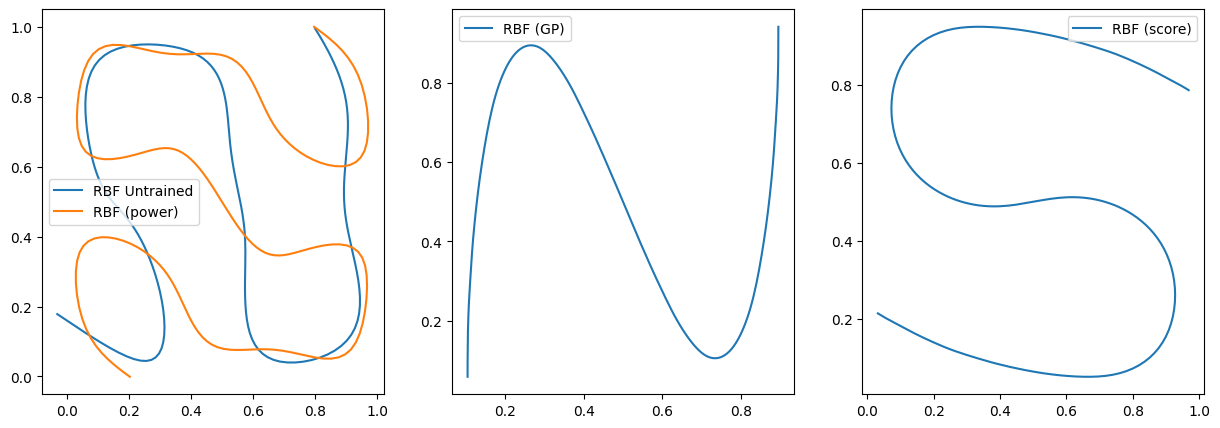

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])

sns.lineplot(
    x=rbf_traj_init_med.w[:, 0], y=rbf_traj_init_med.w[:,1], label="RBF Untrained", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_power_traj_med.w[:, 0], y=rbf_power_traj_med.w[:,1], label="RBF (power)", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_gp_traj_med.w[:, 0], y=rbf_gp_traj_med.w[:,1], label="RBF (GP)", 
    ax=ax[1], sort=False
)
sns.lineplot(
    x=rbf_score_traj_med.w[:, 0], y=rbf_score_traj_med.w[:,1], label="RBF (score)", 
    ax=ax[2], sort=False
)

<Axes: >

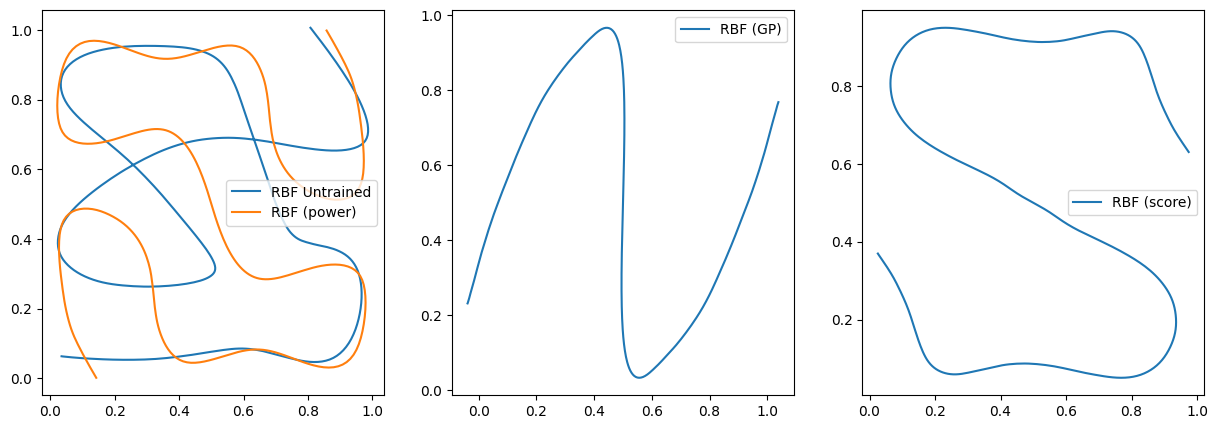

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])

sns.lineplot(
    x=rbf_traj_init_long.w[:, 0], y=rbf_traj_init_long.w[:,1], label="RBF Untrained", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_power_traj_long.w[:, 0], y=rbf_power_traj_long.w[:,1], label="RBF (power)", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_gp_traj_long.w[:, 0], y=rbf_gp_traj_long.w[:,1], label="RBF (GP)", 
    ax=ax[1], sort=False
)
sns.lineplot(
    x=rbf_score_traj_long.w[:, 0], y=rbf_score_traj_long.w[:,1], label="RBF (score)", 
    ax=ax[2], sort=False
)

<Axes: >

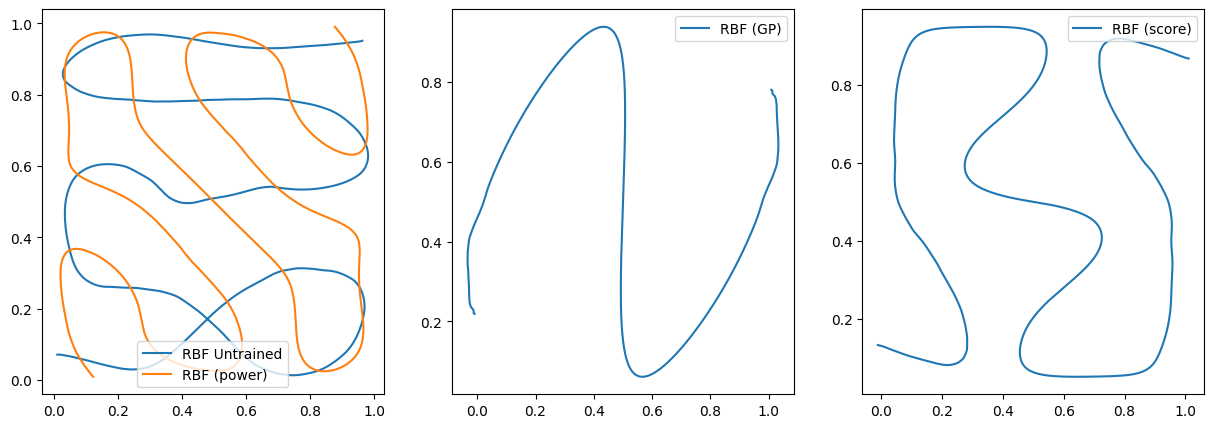

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(
    x=rbf_traj_init_xl.w[:, 0], y=rbf_traj_init_xl.w[:,1], label="RBF Untrained", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_power_traj_xl.w[:, 0], y=rbf_power_traj_xl.w[:,1], label="RBF (power)", 
    ax=ax[0], sort=False
)
sns.lineplot(
    x=rbf_gp_traj_xl.w[:, 0], y=rbf_gp_traj_xl.w[:,1], label="RBF (GP)", 
    ax=ax[1], sort=False
)
sns.lineplot(
    x=rbf_score_traj_xl.w[:, 0], y=rbf_score_traj_xl.w[:,1], label="RBF (score)", 
    ax=ax[2], sort=False
)


In [107]:
sns.set_theme()
sns.set_context("paper", rc={
    # 'font.size': 11,
    # "axes.labelsize": 12,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
})

plt.rcParams.update({
    'font.size': 15,
    'legend.fontsize': 12,
    "axes.titlesize":15,
    "axes.labelsize": 18,
    'text.usetex': True,
    "font.family" : "serif",
    # "font.serif" : ["Times New Roman"],
    'text.latex.preamble': r'\usepackage{times}'
    # 'text.latex.preamble': r'\usepackage{amsfonts}; \usepackage{times}'
})

<Figure size 640x480 with 0 Axes>

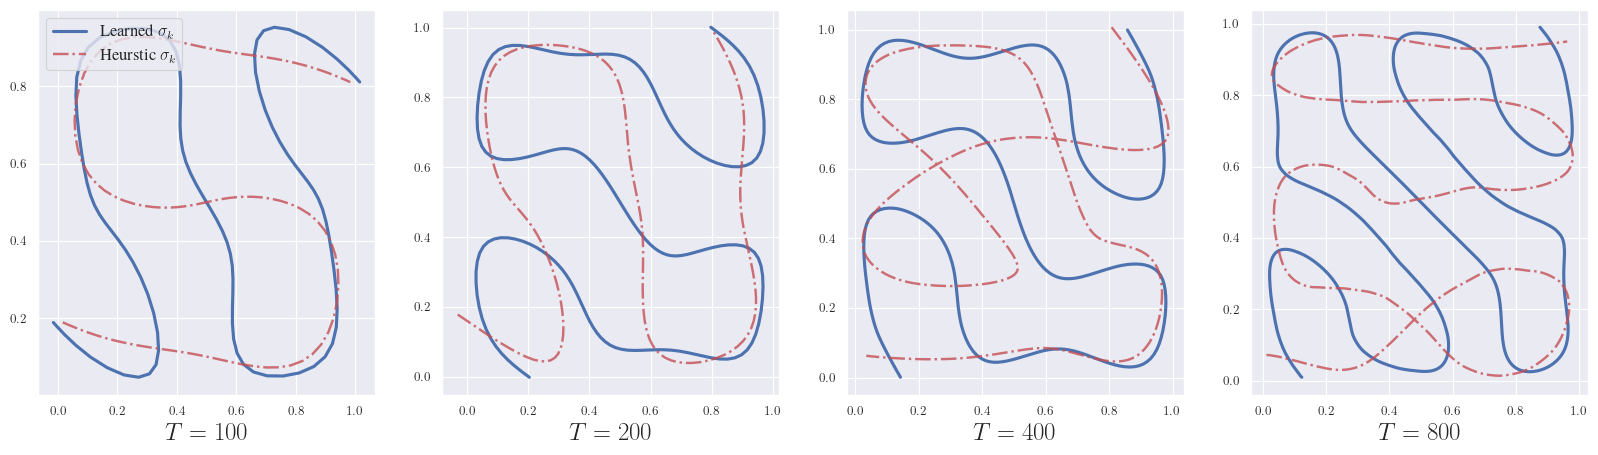

In [109]:
plt.tight_layout()
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

alpha = 0.8
traj_width = 2.25
init_with = 1.75
c_init = 'r'

sns.lineplot(
    x=rbf_power_traj.w[:, 0], y=rbf_power_traj.w[:,1],
    ax=ax[0], sort=False, label="Learned $\sigma_k$", linewidth=traj_width
)
sns.lineplot(
    x=rbf_traj_init.w[:, 0], y=rbf_traj_init.w[:,1],
    ax=ax[0], sort=False, linestyle="-.", alpha=alpha, label="Heurstic $\sigma_k$",
    linewidth=init_with, c=c_init
)
ax[0].set_xlabel("$T = 100$")
ax[0].legend(loc='upper left')

sns.lineplot(
    x=rbf_power_traj_med.w[:, 0], y=rbf_power_traj_med.w[:,1],
    ax=ax[1], sort=False, linewidth=traj_width
)
sns.lineplot(
    x=rbf_traj_init_med.w[:, 0], y=rbf_traj_init_med.w[:,1],
    ax=ax[1], sort=False, linestyle="-.", alpha=alpha,  linewidth=init_with, c=c_init
)
ax[1].set_xlabel("$T = 200$")

sns.lineplot(
    x=rbf_power_traj_long.w[:, 0], y=rbf_power_traj_long.w[:,1] ,
    ax=ax[2], sort=False, linewidth=traj_width
)
sns.lineplot(
    x=rbf_traj_init_long.w[:, 0], y=rbf_traj_init_long.w[:,1],
    ax=ax[2], sort=False, linestyle="-.", alpha=alpha, linewidth=init_with, c=c_init
)
ax[2].set_xlabel("$T = 400$")
sns.lineplot(
    x=rbf_power_traj_xl.w[:, 0], y=rbf_power_traj_xl.w[:,1],
    ax=ax[3], sort=False, linewidth=traj_width,
)
sns.lineplot(
    x=rbf_traj_init_xl.w[:, 0], y=rbf_traj_init_xl.w[:,1],
    ax=ax[3], sort=False, linestyle="-.", alpha=alpha, linewidth=init_with, c=c_init
)
ax[3].set_xlabel("$T = 800$")

fig.savefig("uniform.pdf", bbox_inches='tight')

## Metrics

In [29]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [30]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=100)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=100)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=100)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=100)

In [31]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(5.1385142, dtype=float64),
 Array(4.70186206, dtype=float64),
 Array(10.69795038, dtype=float64),
 Array(5.83814621, dtype=float64))

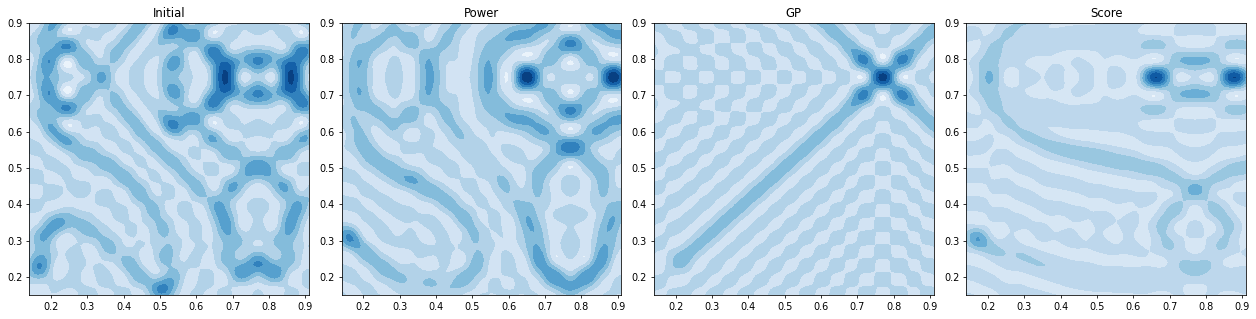

In [124]:
# visualize for comparison
fig, axes = plt.subplots(1, 4, figsize=(18,5), dpi=70, tight_layout=True)

ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Initial')
ax.contourf(X_grid[:, :, 0], X_grid[:,:, 1], rbf_init_erg.reshape(100,100), cmap='Blues')

ax = axes[1]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Power')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_power_erg.reshape(100,100), cmap='Blues')

ax = axes[2]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('GP')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_gp_erg.reshape(100,100), cmap='Blues')

ax = axes[3]
ax.set_aspect('equal')
ax.set_xlim(lb[0], ub[0])
ax.set_ylim(lb[1], ub[1])
ax.set_title('Score')
ax.contourf(X_grid[:,:, 0], X_grid[:,:, 1], rbf_score_erg.reshape(100,100), cmap='Blues')

plt.show()
plt.close()